In [1]:
import torch

In [2]:
GPU_NUM = 0
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  0
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
from load_data import *

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_german_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

(array([130.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 570.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

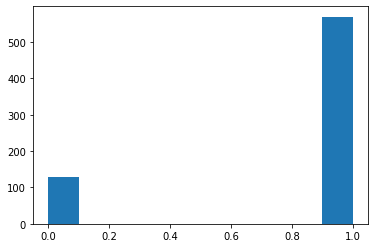

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])

In [6]:
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)


# training samples: (700, 23)
# test samples: (300, 23)
# sensitive vars (700, 1)


In [7]:
N1 = 200
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
from fairNN_train import *
from load_data import *

In [10]:
n_features = Xtr.shape[1]
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [11]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

In [12]:
from fair_eval import *

In [13]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=32, shuffle=False, drop_last=False)

In [14]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, drop_last=False)

- gradient calculation for unlabeled set
- expectation 
- https://discuss.pytorch.org/t/how-to-efficiently-compute-gradient-for-each-training-sample/60001/2 
- https://github.com/cybertronai/autograd-hacks#per-example-gradients 
- https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html

In [15]:
class args:
    epochs = 20
    log_interval = 10

In [16]:
n_features = Xtr.shape[1]
clf = Classifier(n_features=n_features).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(clf.parameters())

In [17]:
clf.eval()
preds = clf(torch.tensor(Xtr[:10],dtype = torch.float32).cuda())

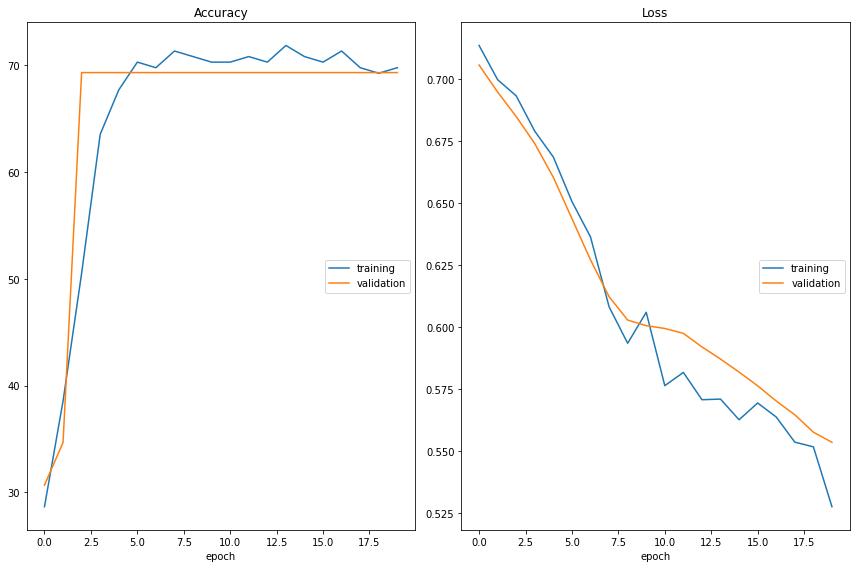

Accuracy
	training         	 (min:   28.646, max:   71.875, cur:   69.792)
	validation       	 (min:   30.667, max:   69.333, cur:   69.333)
Loss
	training         	 (min:    0.528, max:    0.713, cur:    0.528)
	validation       	 (min:    0.554, max:    0.706, cur:    0.554)
Finished Training


In [18]:
train_model(clf, train_loader, criterion, optimizer, device, args, test_loader)

In [19]:
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
def divide_groupsDL(x,y,z, batch_size = 32):
    zs = transform_dum2cat(z)
#     print(zs)
    zsu = np.unique(zs)
    dataloaders = {}
    for zu in zsu:
        z_idx = zs == zu
        xx = x[z_idx]
        yy = y[z_idx]
        daloader = DataLoader(NPsDataSet(xx,yy),batch_size = 32,shuffle=False)
        dataloaders[zu]= daloader
    return dataloaders

In [20]:
dldic = divide_groupsDL(Xtr1,ytr1,Ztr1)

In [21]:
dldic

{0.0: <torch.utils.data.dataloader.DataLoader at 0x7f675a698d30>,
 1.0: <torch.utils.data.dataloader.DataLoader at 0x7f675a605d90>}

# Group Selection Part

In [22]:
def group_grad(clf, dldic, criterion):
    grads={}
    clf.eval()
    for did in dldic:
        print(did)
        for i,(x,y) in enumerate(dldic[did]):
            x = x.to(device)
            y = y.to(device)
            clf.zero_grad()
            outs = clf(x)
            criterion(outs,y).backward()
            tmp = []
            for param in clf.parameters():
                tmp.append(param.grad.flatten())
            grads_t = torch.cat(tmp)
            if i==0:
                grads[did] = grads_t
            else:
                grads[did] += grads_t
        prgrad_n = torch.norm(grads[did])
        grads[did] /= prgrad_n
    return grads

In [23]:
grads = group_grad(clf,dldic, criterion)

0.0
1.0


In [24]:
grads[1.0].shape

torch.Size([2913])

In [25]:
import autograd_hacks

In [27]:
def clear_backprops(model: nn.Module) -> None:
    """Delete layer.backprops_list in every layer."""
    for layer in model.modules():
        if hasattr(layer, 'backprops_list'):
            del layer.backprops_list


In [62]:
def remove_backprops(model: nn.Module):
    """Delete layer.backprops_list in every layer."""
    for layer in model.modules():
        if hasattr(layer, 'backprops_list'):
            del layer.backprops_list[:-1]


In [39]:
def count_backprops(model: nn.Module) -> None:
    """Delete layer.backprops_list in every layer."""
    for layer in model.modules():
        if hasattr(layer, 'backprops_list'):
            print(len(layer.backprops_list))

In [49]:
count_backprops(clf)
clear_backprops(clf)

11
11
11
11


In [50]:
count_backprops(clf)

In [60]:
ll = [1,2,3,4,5]
del ll[:3]
print(ll)

[4, 5]


In [95]:
def compute_gradsim(clf, select_loader, criterion, grad_z):
    clf.eval()
    # criterion2 = nn.BCELoss(reduction = 'none')
    autograd_hacks.add_hooks(clf)
    sims = []
    for i, (x,y,_) in enumerate(select_loader):
    #      print(x.shape,y.shape)

        x = x.to(device)
        y = y.to(device)
        clf.zero_grad()
        clear_backprops(clf)
        outs = clf(x)
        count_backprops(clf)
        criterion(outs,y).backward()
        remove_backprops(clf)
    #     loss_f.backward(gradient=torch.ones_like(loss_f))
    #     grads = torch.autograd.grad(y, clf.parameters(), grad_outputs=torch.ones(y.size()))
    #     count_backprops(clf)
        autograd_hacks.compute_grad1(clf)
        tmp = []
        for j, param in enumerate(clf.parameters()):
    #         print(param.grad.shape)
            tmp.append(param.grad1.reshape(x.size(0),-1))
    #         print(tmp[-1].shape)
        grad_t = torch.cat(tmp,dim=1)
    #     print(grad_t.shape)
    #     sims.append([torch.matmul(grad_t,grads[gid]) for gid in grads.keys()])
        sims.append(torch.matmul(grad_t,grad_z))
    #     for gid in grads.keys():
    # #         print(grad_t.shape)
    # #         print(grads[gid].shape)
    #         print(torch.matmul(grad_t,grads[gid]).shape)
    return torch.cat(sims)


In [96]:
compute_gradsim(clf, select_loader, criterion, grads[1.0])

tensor([-2.3361e-01, -3.6369e-01,  3.5140e-01, -2.0487e+00,  3.9741e-01,
        -3.8724e-02,  4.2591e-01, -2.1446e-01, -1.3888e+00,  3.3567e-01,
         3.9057e-01,  2.8122e-02, -2.1676e-01, -8.5839e-01,  6.2623e-02,
        -1.8664e+00,  2.7366e-01, -1.0335e+00,  3.5134e-01,  3.3114e-01,
         4.3932e-01,  3.5080e-01,  2.8084e-01,  3.8922e-01,  5.0225e-02,
         3.5668e-01,  3.3989e-01,  4.1584e-01,  4.1987e-01,  3.4265e-01,
         1.6359e-01,  3.7051e-01,  1.9898e-01,  2.7688e-01,  3.6638e-01,
         5.1164e-02,  3.0955e-01, -1.6840e+00, -7.1845e-01, -6.8717e-01,
         1.0868e-01,  3.1580e-01,  3.8308e-01,  3.7327e-01,  4.0674e-01,
         4.1630e-01,  3.8410e-01,  2.8101e-01,  1.3268e-01,  2.4796e-01,
         3.0211e-01,  2.8037e-01, -6.2827e-02,  3.9424e-01, -3.2933e-01,
         2.8326e-01,  3.5722e-01,  4.0811e-01, -2.7653e-01,  4.0206e-01,
        -4.3171e-02,  2.4758e-01,  2.7574e-01,  3.7481e-01, -1.0185e+00,
         4.0960e-01,  3.5277e-01,  3.5638e-01, -1.1

In [42]:
for params in clf.parameters():
    print(params.grad1.shape)

torch.Size([32, 32, 50])
torch.Size([32, 32])
torch.Size([32, 32, 32])
torch.Size([32, 32])
torch.Size([32, 32, 32])
torch.Size([32, 32])
torch.Size([32, 1, 32])
torch.Size([32, 1])


In [39]:
for ly in clf.modules():
    if ly.__class__.__name__ in _supported_layers:
        print("backprop",ly.backprops_list[0].shape)

backprop torch.Size([32, 32])
backprop torch.Size([32, 32])
backprop torch.Size([32, 32])
backprop torch.Size([32, 1])


In [35]:
loss_f.shape

torch.Size([32, 1])

In [36]:
clear_backprops(clf)

In [59]:
_supported_layers = ['Linear', 'Conv2d']
# print(ly.__class__.__name__)
for ly in clf.modules():
#     print(ly)
    if ly.__class__.__name__ in _supported_layers:
        print("backprop",ly.backprops_list[-2])

backprop tensor([[ 0.0056,  0.0000,  0.0000,  ...,  0.0035,  0.0026, -0.0058],
        [ 0.0050,  0.0000,  0.0068,  ...,  0.0033,  0.0000, -0.0055],
        [-0.0009,  0.0000, -0.0011,  ..., -0.0006,  0.0000,  0.0000],
        ...,
        [-0.0021,  0.0000, -0.0027,  ..., -0.0013,  0.0000,  0.0021],
        [-0.0028,  0.0000, -0.0034,  ..., -0.0018,  0.0000,  0.0026],
        [-0.0010,  0.0000, -0.0013,  ..., -0.0006,  0.0000,  0.0010]],
       device='cuda:0')
backprop tensor([[-3.0799e-03, -2.1220e-04,  1.8628e-03,  ...,  2.9703e-03,
         -2.1668e-03,  0.0000e+00],
        [-3.0215e-03, -2.0818e-04,  1.8275e-03,  ...,  0.0000e+00,
         -2.1258e-03,  0.0000e+00],
        [ 4.5421e-04,  7.5004e-05, -2.5287e-04,  ..., -4.6722e-04,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.1355e-03,  7.8235e-05, -6.8679e-04,  ..., -1.0951e-03,
          7.9887e-04,  0.0000e+00],
        [ 1.5219e-03,  1.0486e-04, -9.2049e-04,  ..., -1.4677e-03,
          0.0000e+00,  0.0000e+0

In [109]:
grads = group_grad(clf, dldic,criterion)

In [110]:
torch.norm(grads[1.0])

tensor(1., device='cuda:0')

## gradient practice (autograd_hacks)

In [21]:
for i, (x,y,z) in enumerate(select_loader):
    x = x.to(device)
    y = y.to(device)
    if i>1:
        break

In [22]:
from autograd_hacks import *

In [79]:
add_hooks(clf)
outs = clf(x)
loss_f = criterion(outs,y)
loss_f.backward()

In [80]:
loss_f.retain_grad

<bound method Tensor.retain_grad of tensor(0.4250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)>

In [56]:
import torch.nn as nn
grads = []
for param in clf.parameters():
    grads.append(param.grad)

In [59]:
grads[0]/torch.norm(grads[0])

tensor([[ 0.0084, -0.0038,  0.0236,  ...,  0.0000,  0.0126,  0.0400],
        [ 0.0119, -0.0065,  0.0366,  ...,  0.0000,  0.0182,  0.0659],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0003],
        ...,
        [ 0.0034, -0.0017,  0.0177,  ...,  0.0000,  0.0076,  0.0234],
        [ 0.0000, -0.0023,  0.0160,  ...,  0.0000,  0.0089,  0.0251],
        [ 0.0000, -0.0015,  0.0366,  ...,  0.0000,  0.0100,  0.0398]],
       device='cuda:0')

In [15]:
from fair_eval import calculate_prule_clf, calculate_odds_clf, calculate_parity_reg, calculate_group_loss,l2_loss, calculate_overall_accuracy

In [58]:
pred = (clf(torch.tensor(Xte).float())>0.5).float()
pred = pred.cpu().detach().numpy().flatten()

In [59]:
pred_ = clf(torch.tensor(Xte).float())
pred_ = pred_.cpu().detach().numpy().flatten()

In [60]:
print(pred_)

[2.3538221e-01 1.2413255e-03 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 2.0511901e-01 1.0000000e+00 9.6937490e-01
 9.9749798e-01 9.9981707e-01 1.0000000e+00 9.9999428e-01 9.9767429e-01
 1.0000000e+00 9.9999225e-01 8.9258230e-01 1.0000000e+00 1.5512447e-01
 3.9171115e-02 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 9.9999976e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00 6.2504935e-04
 1.0000000e+00 1.0000000e+00 9.9999893e-01 9.9998915e-01 1.0654778e-04
 8.3752722e-01 1.5092101e-03 6.6149596e-04 9.9966538e-01 1.0000000e+00
 1.0000000e+00 9.9997866e-01 1.5397543e-02 1.0000000e+00 9.9881738e-01
 9.7381896e-01 9.1319686e-01 9.9588531e-01 1.0000000e+00 9.7905046e-01
 5.4246902e-02 1.6641982e-04 1.0000000e+00 1.0000000e+00 1.7419867e-03
 1.0000000e+00 1.0000000e+00 1.3249847e-01 7.8252349e-03 4.2536462e-04
 9.9997997e-01 4.9439285e-02 1.0000000e+00 5.3632051e-01 1.9662890e-03
 1.0000000e+00 9.9866188e-01 9.9999988e-01 9.9997520e-01 2.8819951e-01
 9.997

In [62]:
calculate_prule_clf(pred,yte,Zte)

disparate impact:  78.72340425531915
disparate misclassification rate:  55.769230769230774
disparate false positive rate: 89.1891891891892
disparate false negative rate: 44.94252873563219


In [64]:
calculate_odds_clf(pred,yte.flatten(),Zte)

equalized opportunity for 0.0 : 89.1891891891892
equalized opportunity for 1.0 : 81.34008570315544


In [46]:
calculate_group_loss(bce_loss,pred_,y_te,xs_te)

NameError: name 'bce_loss' is not defined

In [61]:
calculate_overall_accuracy(pred,yte.flatten())

0.7233333333333334

In [78]:
min([1,3,5,6])

1